# Inport Necessary Libralies

In [13]:
import praw
import configparser
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Set up configuration

In [14]:
#Define the broad search term (replaces the 'search_phrases' list)
SEARCH_TERM = '(Cybertruck Problems OR Cybertruck Issues OR Cybertruck Rust)'

# Set up search conditions (re-stating for clarity, assuming they are defined earlier)
SUBREDDITS = ['teslamotors', 'RealTesla', 'cars', 'technology']
POST_LIMIT = 1000

# Read config.ini
config = configparser.ConfigParser()
config.read('config.ini')

# Initialise Praw Client
try:
    # user authentication
    reddit = praw.Reddit(
        client_id=config['reddit']['client_id'],
        client_secret=config['reddit']['client_secret'],
        user_agent=config['reddit']['user_agent'],
        username=config['reddit']['username'],
        password=config['reddit']['password']
    )
    # Ensure the log in successful.
    print(f"PRAW client initialized. Logged in as: {reddit.user.me().name}")

except KeyError as e:
    print(f"FATAL ERROR: Missing Reddit credential in config.ini. Check key: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during PRAW initialization or login: {e}")
    exit()

PRAW client initialized. Logged in as: Afraid-Medicine4769


# Retrive and Collect Submissions

In [15]:
# Define the flexible search terms for Python to check
search_phrases = ['cybertruck', 'tesla truck', 'musk truck', 'stainless steel rust']

collected_posts = []

print(f"\n--- Starting data collection across {len(SUBREDDITS)} subreddits ---")

for subreddit_name in SUBREDDITS:
    print(f"Searching r/{subreddit_name}...")
    try:
        subreddit = reddit.subreddit(subreddit_name)
        
        # Keep .new() but for smaller subreddits
        for submission in subreddit.new(limit=POST_LIMIT):
            
            # Combine the title and text to search for the term, and convert to lowercase
            full_content = (submission.title + ' ' + submission.selftext).lower()
            
            # Filter the posts yourself in Python for any of the flexible phrases
            if any(phrase in full_content for phrase in search_phrases):
                collected_posts.append({
                    'id': submission.id,
                    'subreddit': subreddit_name,
                    'title': submission.title,
                    'text': submission.selftext,
                    'score': submission.score,
                    'num_comments': submission.num_comments,
                    'created_utc': submission.created_utc,
                    'url': submission.url
                })
            
    except Exception as e:
        print(f"Skipping r/{subreddit_name} due to an error: {e}")
        continue # Move to the next subreddit

print(f"\nData Collection Complete. Total submissions collected: {len(collected_posts)}")


--- Starting data collection across 4 subreddits ---
Searching r/teslamotors...
Searching r/RealTesla...
Searching r/cars...
Searching r/technology...

Data Collection Complete. Total submissions collected: 226


## Convert the retrieved to a dataframe to display sample

In [16]:
if collected_posts:
    df = pd.DataFrame(collected_posts)
    
    # Convert timestamp
    df['created_at'] = pd.to_datetime(df['created_utc'], unit='s')
    
    print("\nSample of Retrieved Data (First 5 Rows)")
    print(df[['subreddit', 'title', 'score', 'num_comments', 'created_at']].head())
else:
    print("\nNo posts were found matching the search criteria.")


Sample of Retrieved Data (First 5 Rows)
     subreddit                                              title  score  \
0  teslamotors  v14 comments from Tesla employees, cybertruck ...    348   
1  teslamotors  2025 Tesla Cybertruck ratings Good versus Ford...     86   
2  teslamotors         Police vehicles in my city are Cybertrucks    836   
3  teslamotors  Cybertruck hit a peak rate of 483 kW at the ne...    179   
4  teslamotors                     Germany can’t have cybertrucks    971   

   num_comments          created_at  
0           132 2025-10-07 21:10:07  
1            16 2025-10-07 16:06:03  
2            80 2025-10-04 22:26:23  
3            44 2025-09-30 13:21:56  
4           276 2025-09-29 14:38:50  


# Data Cleaning

In [18]:
# 1. Fill missing 'text' (post body) with an empty string
df['text'] = df['text'].fillna('')

# 2. Concatenate the title and the post body
df['full_text'] = df['title'] + ' ' + df['text']

# Display the size of the DataFrame (should be 591)
print(f"DataFrame size after cleaning: {len(df)}")

DataFrame size after cleaning: 226


In [20]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs (starts with http or https)
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove special characters, keeping only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text) 
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to the combined text column
df['clean_text'] = df['full_text'].apply(clean_text)

# Show a sample of the cleaned data
print(df['clean_text'].head())

0    v comments from tesla employees cybertruck con...
1    tesla cybertruck ratings good versus ford f li...
2           police vehicles in my city are cybertrucks
3    cybertruck hit a peak rate of kw at the new v ...
4                        germany cant have cybertrucks
Name: clean_text, dtype: object


# Sentimental Analysis

In [21]:
# Initialize the VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER scores
def get_vader_scores(text):
    vs = analyzer.polarity_scores(text)
    return vs

# Apply the function to the cleaned text column
df['vader_scores'] = df['clean_text'].apply(get_vader_scores)

# Extract the compound score (the normalized, single sentiment metric)
# The compound score ranges from -1 (most negative) to +1 (most positive)
df['compound_score'] = df['vader_scores'].apply(lambda x: x['compound'])

# --- Classify Sentiment ---
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['compound_score'].apply(classify_sentiment)

print("\n--- Sample with Sentiment Scores ---")
print(df[['title', 'compound_score', 'sentiment']].head())


--- Sample with Sentiment Scores ---
                                               title  compound_score sentiment
0  v14 comments from Tesla employees, cybertruck ...          0.0000   Neutral
1  2025 Tesla Cybertruck ratings Good versus Ford...         -0.4404  Negative
2         Police vehicles in my city are Cybertrucks          0.0000   Neutral
3  Cybertruck hit a peak rate of 483 kW at the ne...          0.0000   Neutral
4                     Germany can’t have cybertrucks          0.0000   Neutral


## Overall Sentiment Breakdown

In [22]:
# Calculate the total counts for each sentiment category
sentiment_counts = df['sentiment'].value_counts()

# Calculate the percentage for a clearer presentation
sentiment_percentages = df['sentiment'].value_counts(normalize=True) * 100

print("\n--- Overall Sentiment Breakdown (Counts) ---")
print(sentiment_counts)
print("\n--- Overall Sentiment Breakdown (Percentages) ---")
print(sentiment_percentages.round(2))


--- Overall Sentiment Breakdown (Counts) ---
sentiment
Neutral     100
Positive     73
Negative     53
Name: count, dtype: int64

--- Overall Sentiment Breakdown (Percentages) ---
sentiment
Neutral     44.25
Positive    32.30
Negative    23.45
Name: proportion, dtype: float64


# Data Visualisation

/var/folders/jc/32xy7t714y5clrhjsh4zr3d40000gn/T/ipykernel_13997/92772069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, order=['Negative', 'Neutral', 'Positive'], palette=['#E74C3C', '#F39C12', '#2ECC71'])


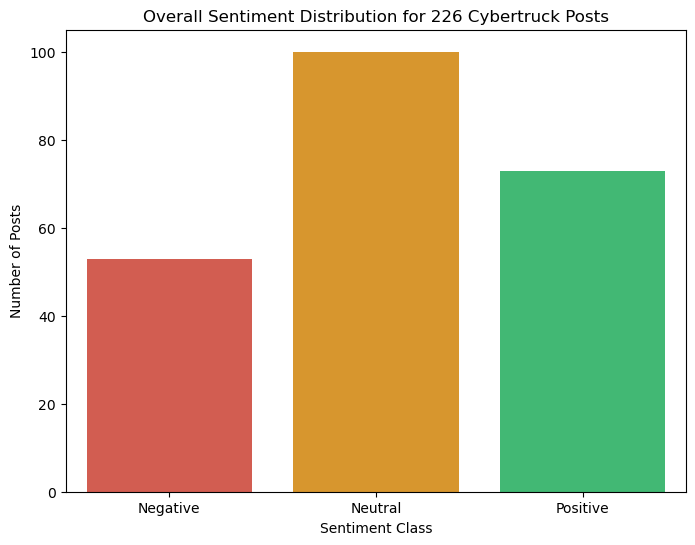

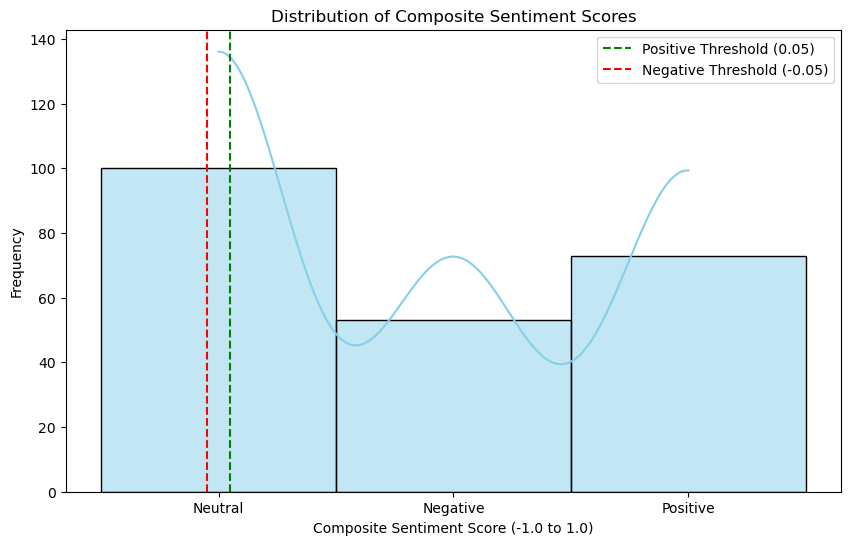

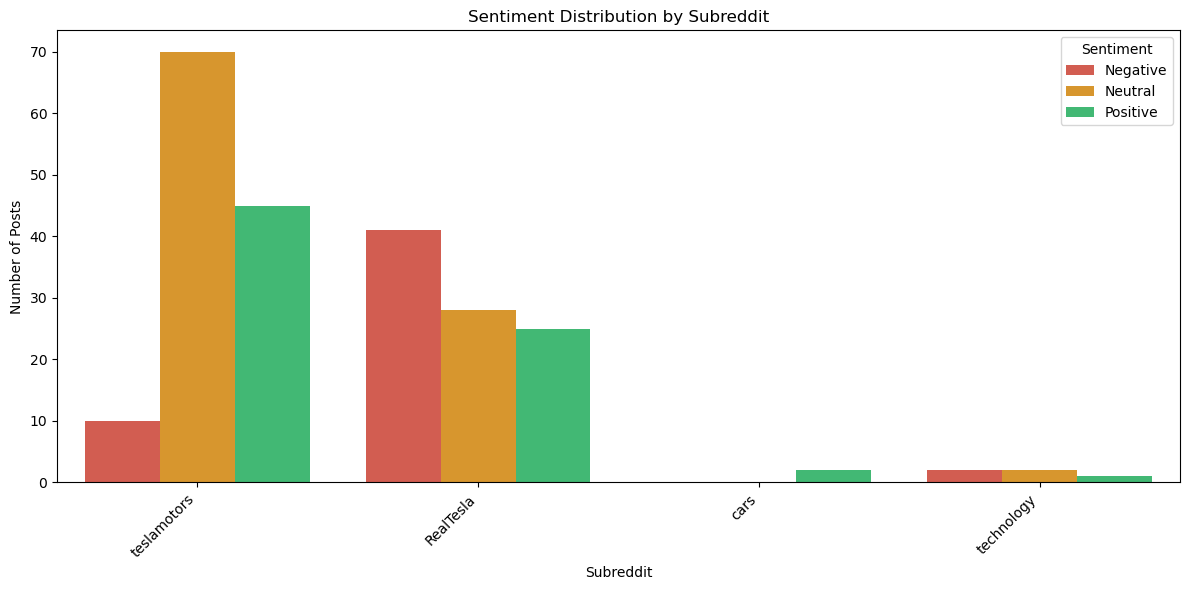

In [26]:
# 1. Overall Sentiment Distribution Bar Chart
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['Negative', 'Neutral', 'Positive'], palette=['#E74C3C', '#F39C12', '#2ECC71'])
plt.title(f'Overall Sentiment Distribution for {len(df)} Cybertruck Posts')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Posts')
plt.show()

# 2. Distribution of Composite Sentiment Scores (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Composite Sentiment Scores')
plt.xlabel('Composite Sentiment Score (-1.0 to 1.0)')
plt.ylabel('Frequency')
plt.axvline(x=0.05, color='green', linestyle='--', label='Positive Threshold (0.05)')
plt.axvline(x=-0.05, color='red', linestyle='--', label='Negative Threshold (-0.05)')
plt.legend()
plt.show()

# 3. Sentiment Distribution by Subreddit (Count Plot)
plt.figure(figsize=(12, 6))
sns.countplot(x='subreddit', hue='sentiment', data=df, 
              hue_order=['Negative', 'Neutral', 'Positive'],
              palette=['#E74C3C', '#F39C12', '#2ECC71'])
plt.title('Sentiment Distribution by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.legend(title='Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Report Key Metrics

In [29]:
# Calculate overall percentages
sentiment_counts = df['sentiment'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print("\nOverall Sentiment Breakdown:")
print(sentiment_counts)

# Get top 5 most engaged posts (highest score) and their sentiment
top_posts = df.sort_values(by='score', ascending=False).head(5)
print("\nTop 5 Most Upvoted Posts (Related to Cybertruck Issues):")
for index, row in top_posts.iterrows():
    print(f"  - Subreddit: r/{row['subreddit']}")
    print(f"    Title: {row['title'][:70]}...")
    print(f"    Score: {row['score']}, Comments: {row['num_comments']}")
    print(f"    Sentiment: {row['sentiment']} ({row['compound_score']:.3f})\n")


Overall Sentiment Breakdown:
sentiment
Neutral     44.2%
Positive    32.3%
Negative    23.5%
Name: proportion, dtype: object

Top 5 Most Upvoted Posts (Related to Cybertruck Issues):
  - Subreddit: r/technology
    Title: Teen was burned alive in malfunctioning Tesla Cybertruck, lawsuit clai...
    Score: 21597, Comments: 1473
    Sentiment: Positive (0.178)

  - Subreddit: r/RealTesla
    Title: Elon’s Edsel: Tesla Cybertruck is the auto industry’s biggest flop in ...
    Score: 9838, Comments: 434
    Sentiment: Negative (-0.340)

  - Subreddit: r/technology
    Title: SpaceX has already taken delivery of hundreds of unsold Tesla Cybertru...
    Score: 6772, Comments: 575
    Sentiment: Neutral (0.000)

  - Subreddit: r/RealTesla
    Title: Tesla is sitting on $200 million worth of Cybertruck inventory...
    Score: 6082, Comments: 538
    Sentiment: Positive (0.226)

  - Subreddit: r/RealTesla
    Title: Cybertruck Sales Are So Bad That We Gasped...
    Score: 3099, Comments: 354
 